In [75]:
%pip install coba cloudpickle torch parameterfree vowpalwabbit --quiet

Note: you may need to restart the kernel to use updated packages.


# Introduction

Below we run several experiments comparing SquareCB Neural Networks to VW.

For these tests we use 80 separate classification datasets from   https://arxiv.org/abs/2007.04074.

In Initial Setup we create our SquareCB Neural Network learner as well as a special evaluator for neural networks.

# Initial Setup

In [54]:
import torch
import coba as cb

class Feedforward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def __init__(self, specs):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                int -- a LinearLayer with output width equal to int
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        def make_layer(curr_dim,spec):
            if isinstance(spec,float):
                return torch.nn.Dropout(spec), curr_dim
            if curr_dim is None and isinstance(spec,int):
                return None, spec
            if isinstance(spec,int):
                return torch.nn.Linear(curr_dim,spec),spec
            if spec == 'r':
                return torch.nn.ReLU(),curr_dim
            if spec == 'l':
                return torch.nn.LayerNorm(curr_dim),curr_dim
            if spec == 's':
                return torch.nn.Sigmoid(),curr_dim
            if isinstance(spec,list):                
                return Feedforward.SkipModule(Feedforward([curr_dim] + spec)), curr_dim

        layers,width = [],None
        for spec in specs:
            layer,width = make_layer(width,spec)
            if layer: layers.append(layer)

        super().__init__(*layers)

class FeedforwardCB(torch.nn.Module):

    def __init__(self, specs, aembed):

        super().__init__()

        self.aembed = torch.nn.Embedding(*aembed) if aembed else lambda x:x
        self.layers = Feedforward(specs)

    def forward(self,context,actions):
        actions = self.aembed(actions)
        context = context.repeat(len(actions),1)
        return self.layers(torch.cat([context,actions],dim=1))

class FeedForwardSquareCb:

    def __init__(self, specs, adim=None, gamma='lambda t: 1000'):
        self.loss   = torch.nn.MSELoss(reduction='none')
        self.fhat    = None
        self.opt     = None
        self.sched   = None
        self._adim   = adim
        self._specs  = specs
        self._params = {'layers': specs, 'gamma':gamma, 'adim':adim}
        self._gamma  = eval(gamma)
        self._rng    = cb.CobaRandom(1)
        self._t      = 1

    @property
    def params(self):
        return self._params

    def define(self,context, actions):
        import parameterfree
        torch.manual_seed(1)
        torch.set_num_threads(1)

        cdim   = len(context)
        adim   = self._adim or len(actions[0])
        xdim   = adim+cdim
        aembed = (len(actions),adim) if self._adim else None

        islist = lambda s: isinstance(s,list)
        isneg1 = lambda s: s == -1

        def prep(specs):
            return [ xdim if isneg1(s) else prep(s) if islist(s) else s for s in specs ]

        self.fhat  = FeedforwardCB(prep(self._specs), aembed)
        self.opt   = parameterfree.COCOB(self.fhat.parameters())

    def predict(self, context, actions):
        if not self.opt: self.define(context,actions)
        
        with torch.no_grad():
            mu = len(actions)
            dt = torch.float32

            x    = torch.tensor(context,dtype=dt)
            A    = torch.tensor(actions,dtype=dt) if not self._adim else torch.arange(len(actions))
            yhat = self.fhat.eval()(x,A)

            rvals       = torch.reshape(yhat, (1,-1))
            rmaxs,ridxs = rvals.max(axis=1,keepdim=True)
            rgaps       = rmaxs-rvals

            probs = 1/(mu+self._gamma(self._t)*rgaps)
            probs[range(1),ridxs.squeeze()] += 1-probs.sum(axis=1)

        return self._rng.choicew(actions,probs[0].tolist())

    def learn(self, context, action, reward, score):
        if not self.opt: self.define(context,actions)

        self._t += 1
        dt = torch.float32

        x    = torch.tensor(context ,dtype=dt)
        A    = torch.tensor([action],dtype=dt) if not self._adim else torch.tensor([action.index(1)])
        y    = torch.tensor([reward],dtype=dt)
        yhat = self.fhat.eval()(x,A)[0]
        loss = self.loss(yhat, y).mean()

        self.opt.zero_grad()
        loss.backward()

        self.opt.step()
        if self.sched: self.sched.step()

class RepeatEval:
    def __init__(self, trn_size, val_size):
        assert trn_size == 0 or val_size > 0
        assert trn_size >= 0 and val_size >=0

        self._trn_size = trn_size
        self._val_size = val_size

    @property
    def params(self):
        return {'trn_size': self._trn_size, 'val_size': self._val_size }

    def evaluate(self, env, lrn):
        from coba.pipes import Pipes, IterableSource, Shuffle
        from operator import itemgetter
        from itertools import islice

        first,rows = cb.peek_first(env.read())

        if first is None: return

        trn = IterableSource(list(islice(rows,self._trn_size)))
        val = IterableSource(list(islice(rows,self._val_size)))
        tst = IterableSource(rows)

        trainer   = cb.SequentialCB(eval=None)
        validator = cb.SequentialCB(record='reward',learn=None)
        tester    = cb.SequentialCB()

        if self._trn_size > 0:
            new_val_score = 0
            for i in range(20): #20 to make sure we don't loop forever (though we shouldn't ever hit 20)
                old_val_score = new_val_score
                if isinstance(lrn, FeedForwardSquareCb): lrn._t = 1 #reset exploration to make sure we fairly compare
                list(trainer.evaluate(Pipes.join(trn,Shuffle(i)),lrn))
                new_val_score = sum(map(itemgetter('reward'),validator.evaluate(val,lrn)))
                if new_val_score < old_val_score: break # our latest iteration on train appears to have overfit, stop training

        yield from tester.evaluate(tst,lrn)

In [30]:
trn_size = 0
val_size = 2

first,rows = cb.peek_first([1,2,3,4])

trn = IterableSource(list(islice(rows,trn_size)))
val = IterableSource(list(islice(rows,val_size)))
tst = IterableSource(rows)

print('Here is an example of what is in each of our environments:')
print(f'    trn = {list(trn.read())}')
print(f'    val = {list(val.read())}')
print(f'    tst = {list(tst.read())}')

print()
print('Here is an example of the Shuffle applied in the loop:')
print(f'    list(Pipes.join(val,Shuffle(5)).read()) = {list(Pipes.join(val,Shuffle(5)).read())}')

Here is an example of what is in each of our environments:
    trn = []
    val = [1, 2]
    tst = [3, 4]

Here is an example of the Shuffle applied in the loop:
    list(Pipes.join(val,Shuffle(5)).read()) = [2, 1]


# Main Results

## 1. Feature scaling matters (with standardization best on average)

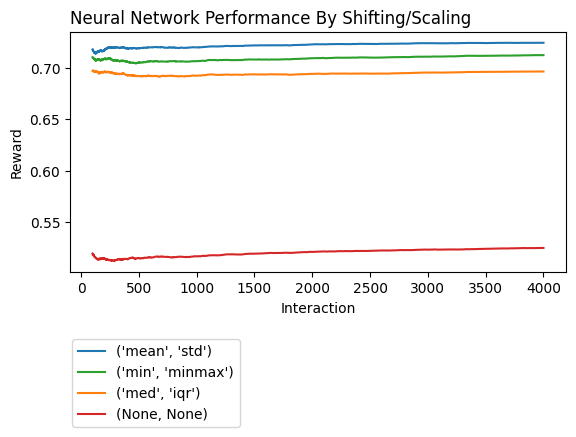

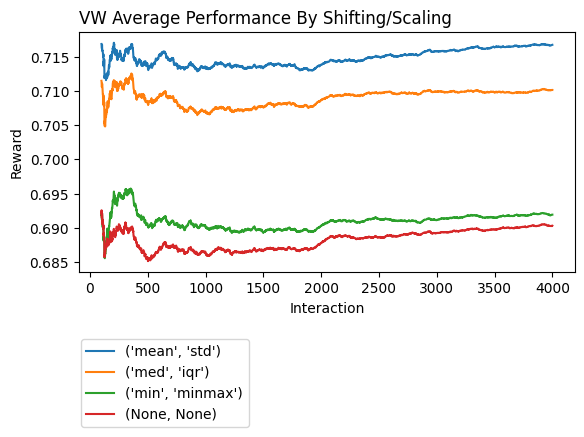

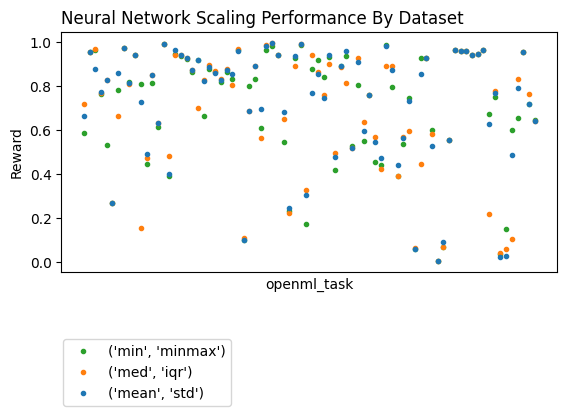

In [36]:
def local(log,cores):

    base_env = cb.Environments.from_feurer().where(n_features=(None,1000)).reservoir(8000,strict=True).cunk()

    env  = base_env
    env += base_env.scale('min' ,'minmax')
    env += base_env.scale('mean','std'   )
    env += base_env.scale('med' ,'iqr'   )

    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 80

    lrn = [
        cb.VowpalEpsilonLearner(features=[1,'a','xa','xxa']),
        FeedForwardSquareCb([-1, width, preres(width), 1], gamma='lambda t:25*t**.5'),
    ]

    return cb.Experiment(env,lrn,RepeatEval(3000,1000)).run(log,processes=cores,maxtasksperchunk=2,quiet=True)

out = local('scaling.log.gz',35)
out.where(learner_id=1).plot_learners(xlim=(100,None),l=['shift','scale'],p='openml_task',title='Neural Network Performance By Shifting/Scaling')
out.where(learner_id=0).plot_learners(xlim=(100,None),l=['shift','scale'],p='openml_task',title='VW Average Performance By Shifting/Scaling')
out.where(learner_id=1).where(scale={'!=':None}).plot_learners(x=['openml_task'],l=['shift','scale'],p='openml_task',xticks=False,title='Neural Network Scaling Performance By Dataset')

## 2. Architecture matters but must be determined per problem for best outcomes

...Though 2 layer resnet generally works pretty well

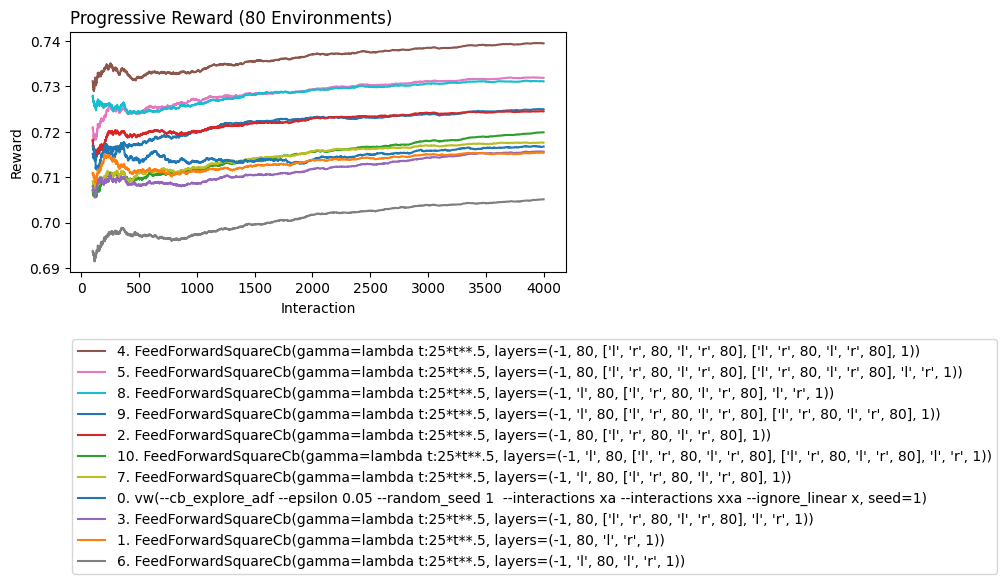

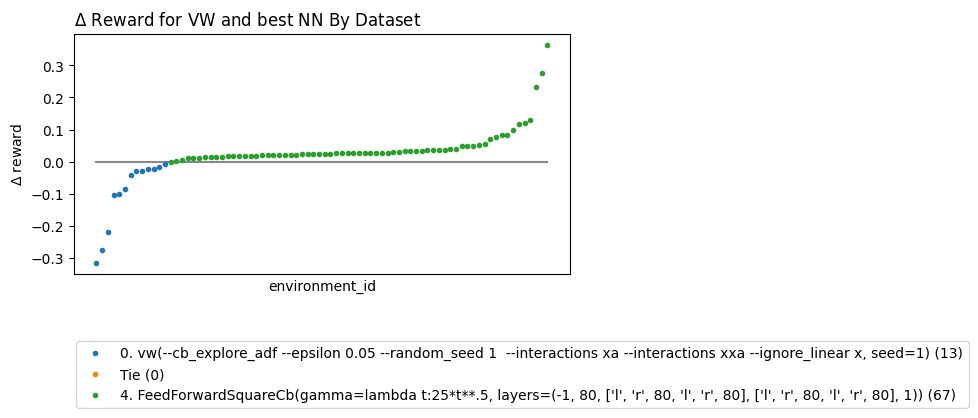

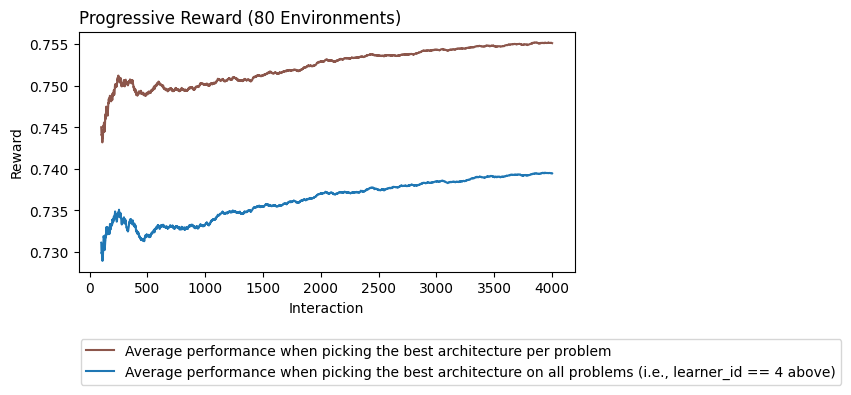

In [38]:
def local(log,cores):
    env = cb.Environments.from_feurer().where(n_features=(None,1000)).reservoir(8000,strict=True).scale('mean','std').chunk()
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 80

    lrn = [
        cb.VowpalEpsilonLearner(features=[1,'a','xa','xxa']),
        FeedForwardSquareCb([-1, width, 'l', 'r', 1], gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, width, preres(width), 1], gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, width, preres(width), 'l', 'r', 1], gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, width, preres(width), preres(width), 1], gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, width, preres(width), preres(width), 'l', 'r', 1], gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, 'l', width, 'l', 'r', 1], gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, 'l', width, preres(width), 1], gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, 'l', width, preres(width), 'l', 'r', 1], gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, 'l', width, preres(width), preres(width), 1], gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, 'l', width, preres(width), preres(width), 'l', 'r', 1], gamma='lambda t:25*t**.5'),
    ]

    return cb.Experiment(env,lrn,RepeatEval(3000,1000)).run(log,processes=cores,maxtasksperchunk=2,quiet=True)

out = local('networks.log.gz',35)
out.plot_learners(xlim=(100,None))
out.plot_contrast(0,4,xticks=False,title="$\Delta$ Reward for VW and best NN By Dataset")
out.where(learner_id={'!=':0}).where_best(l='family').plot_learners(xlim=(100,None),l='family',colors=5,labels='Average performance when picking the best architecture per problem',out=None)
out.where(learner_id=4).plot_learners(xlim=(100,None),labels='Average performance when picking the best architecture on all problems (i.e., learner_id == 4 above)')

## 3. Wider is generally better (all else held equal)

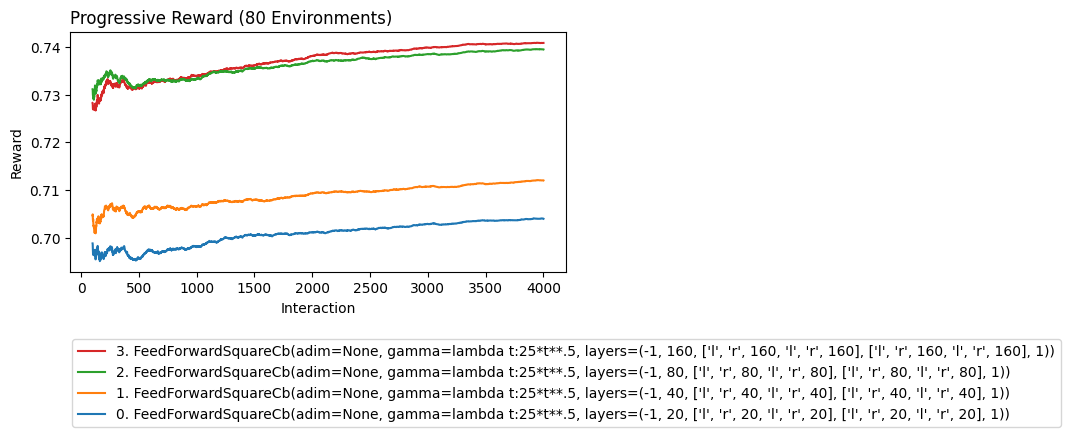

In [8]:
def local(log,cores):

    env = cb.Environments.from_feurer().where(n_features=(None,1000)).reservoir(8000,strict=True).scale('mean','std').chunk()

    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    twopreres = lambda width: [-1, width, preres(width), preres(width), 1]

    lrn = [
        FeedForwardSquareCb(twopreres(width=20) , gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb(twopreres(width=40) , gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb(twopreres(width=80) , gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb(twopreres(width=160), gamma='lambda t:25*t**.5'),
    ]

    return cb.Experiment(env,lrn,RepeatEval(3000,1000)).run(log,processes=cores,maxtasksperchunk=2,quiet=True)

out = local('widths.log.gz',35)
out.plot_learners(xlim=(100,None))

## 4. Embedding one-hot actions can give some lift but must be tuned per problem

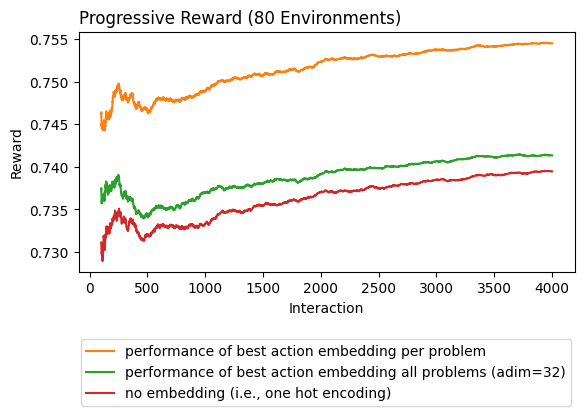

CPU times: user 1.23 s, sys: 208 ms, total: 1.44 s
Wall time: 1.21 s


In [46]:
%%time
def local(log,cores):

    env    = cb.Environments.from_feurer().where(n_features=(None,1000)).reservoir(8000,strict=True).scale('mean','std').chunk()
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 80

    lrn = [
        FeedForwardSquareCb([-1, width, preres(width), preres(width), 1],          gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, width, preres(width), preres(width), 1], adim=8 , gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, width, preres(width), preres(width), 1], adim=16, gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, width, preres(width), preres(width), 1], adim=32, gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, width, preres(width), preres(width), 1], adim=64, gamma='lambda t:25*t**.5'),
    ]

    return cb.Experiment(env,lrn,RepeatEval(3000,1000)).run(log,processes=cores,maxtasksperchunk=1,quiet=True)

out = local('adims.log.gz',35)
out.where(learner_id={'!=':0}).where_best(l='family').plot_learners(xlim=(100,None),l='family',colors=1,labels='performance of best action embedding per problem',out=None)
out.where(learner_id={'=':3}).where_best(l='family').plot_learners(xlim=(100,None),l='family',colors=2,labels='performance of best action embedding all problems (adim=32)',out=None)
out.where(learner_id={'=':0}).plot_learners(xlim=(100,None), colors=3, labels='no action embedding (i.e., one hot encoding)')

## 5. Experience Replay Is Neccesary for CB Neural Networks to Beat VW

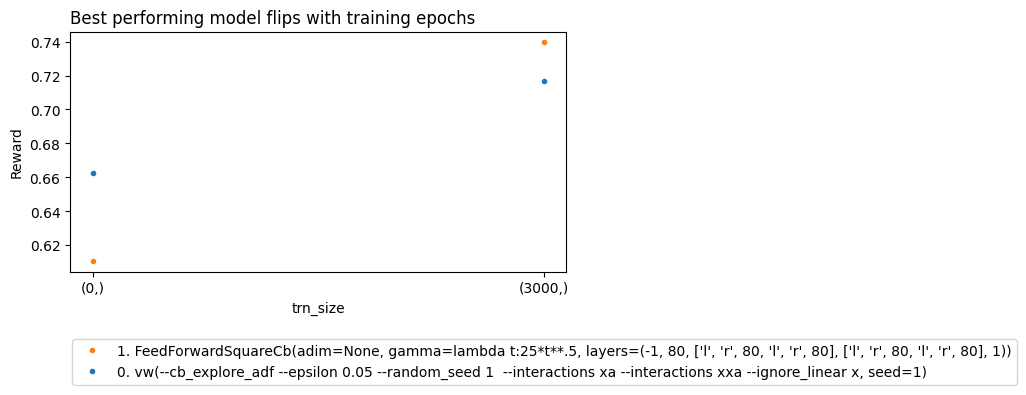

In [73]:
def local(log,cores):

    env    = cb.Environments.from_feurer().where(n_features=(None,1000)).reservoir(8000,strict=True).scale('mean','std').chunk()
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 80

    lrn = [
        cb.VowpalEpsilonLearner(features=[1,'a','xa','xxa']),
        FeedForwardSquareCb([-1, width, preres(width), preres(width), 1], gamma='lambda t:25*t**.5'),
    ]

    evals = [
        RepeatEval(3000,1000),
        RepeatEval(0   ,4000) #this will simply skip the first 4,000 examples and evaluate on the final 4,000
    ]

    return cb.Experiment(env,lrn,evals).run(log,processes=cores,maxtasksperchunk=1,quiet=True)

#out = local('replays.log.gz',35)
out.plot_learners(l='full_name', x =['trn_size'],p=None,title='Best performing model flips with training epochs')